In [3]:
!pip install missingno MissForest lazypredict



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from missforest import MissForest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import (
    r2_score,
    median_absolute_error,
    mean_absolute_percentage_error
)

import warnings
warnings.filterwarnings("ignore")






# Análisis Exploratorio de Datos (EDA) - AB_NYC_2019

En este notebook vamos a:

1. Cargar y explorar los datos.
2. Eliminar columnas inútiles (constantes).
3. Revisar y tratar duplicados.
4. Analizar valores faltantes y decidir qué hacer.
5. Filtrar datos extremos (price, minimum_nights).
6. Detectar outliers (Isolation Forest).
7. Preparar datos para modelado:
   - Train/Test split
   - Imputación de nulos (MissForest)
   - Codificación de categóricas (OneHotEncoder)
   - Escalado de variables (StandardScaler)
8. Hacer un modelo básico de Random Forest y ver importancia de variables.

Al final hay una sección marcada como **EXTRA / OPCIONAL** con cosas más avanzadas.


1.Cargar los datos

In [5]:
df = pd.read_csv("../data/raw/AB_NYC_2019.csv")
df.set_index('id', inplace=True)
pd.set_option('display.max_columns', None)
df.head()




,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
df.shape

(48895, 15)

2.CRIBADO MANUAL


2.1 Carga y exploración inicial de los datos

Comenzamos cargando el dataset y realizando una exploración inicial para conocer su estructura, dimensiones y tipos de datos. Esta revisión nos permite identificar posibles variables irrelevantes, errores de formato o valores extremos desde el inicio.


In [7]:
df.shape
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 48895 entries, 2539 to 36487245
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month              

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


2.2 Descripción general del dataset

Analizamos las estadísticas básicas y el tipo de información contenida en cada columna. Esto nos ayuda a clasificar las variables (numéricas, categóricas o textuales) y a detectar posibles problemas antes del preprocesamiento.

In [8]:
df.describe(include='all')


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,48879,4.889500e+04,48874,48895,48895,48895.000000,48895.000000,48895,48895.000000,48895.000000,48895.000000,38843,38843.000000,48895.000000,48895.000000
unique,47905,NaN,11452,5,221,NaN,NaN,3,NaN,NaN,NaN,1764,NaN,NaN,NaN
top,Hillside Hotel,NaN,Michael,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,2019-06-23,NaN,NaN,NaN
freq,18,NaN,417,21661,3920,NaN,NaN,25409,NaN,NaN,NaN,1413,NaN,NaN,NaN
mean,NaN,6.762001e+07,NaN,NaN,NaN,40.728949,-73.952170,NaN,152.720687,7.029962,23.274466,NaN,1.373221,7.143982,112.781327
std,NaN,7.861097e+07,NaN,NaN,NaN,0.054530,0.046157,NaN,240.154170,20.510550,44.550582,NaN,1.680442,32.952519,131.622289
min,NaN,2.438000e+03,NaN,NaN,NaN,40.499790,-74.244420,NaN,0.000000,1.000000,0.000000,NaN,0.010000,1.000000,0.000000
25%,NaN,7.822033e+06,NaN,NaN,NaN,40.690100,-73.983070,NaN,69.000000,1.000000,1.000000,NaN,0.190000,1.000000,0.000000
50%,NaN,3.079382e+07,NaN,NaN,NaN,40.723070,-73.955680,NaN,106.000000,3.000000,5.000000,NaN,0.720000,1.000000,45.000000
75%,NaN,1.074344e+08,NaN,NaN,NaN,40.763115,-73.936275,NaN,175.000000,5.000000,24.000000,NaN,2.020000,2.000000,227.000000


MI OBSERVACIONES Y EXPLICACION:
variable objetivo: price
1....Mi variable objetivo es el precio del alojamiento (price). Lo que quiero es predecir cuánto cuesta una noche en un Airbnb en función de las características del anuncio, del anfitrión y de la zona. El precio es una variable numérica continua y tiene sentido como objetivo en un problema de regresión.

2...variables importantes:
host_id es el identificador numérico del anfitrión. No es el nombre, sino un código. Lo uso para contar cuántos anuncios gestiona cada host y, a partir de ahí, defino si es profesional o no.

2.3 Identificación y eliminación de duplicados

Verificamos si existen registros duplicados en el dataset, ya que su presencia puede distorsionar el análisis o el entrenamiento del modelo. En caso de encontrarlos, los eliminamos.

In [9]:
### Eliminamos duplicados para evitar que el modelo aprenda información repetida.
df.duplicated().sum()
df.drop_duplicates(inplace=True)


2.4 Eliminación de columnas no relevantes

Retiramos variables que no aportan información útil para el modelo o que contienen datos personales:

host_name → información personal no útil para la predicción.

name → nombre del alojamiento, no contribuye a un análisis o modelo robusto.

In [10]:
df.drop(['host_name', 'name'], axis=1, inplace=True)
df.head()
### He eliminado columnas como host_name
# y name porque son texto personal y no aportan valor al modelo.”

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,
2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


2.5 Análisis de valores faltantes

Revisamos cuántos valores faltantes hay por columna y su porcentaje respecto al total.
 Esto nos permite decidir si se deben eliminar o imputar.


In [11]:
### Cuando faltaba reviews_per_month,
#  lo imputé con 0 ya que lo interpreté como que no tuvo reseñas en ese periodo
df.isnull().sum()
(df.isnull().sum() / len(df)) * 100


host_id                            0.000000
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

En caso de que una columna relevante tenga pocos valores faltantes, aplicamos imputación.
Ejemplo aplicado a reviews_per_month:

### minimum_nights indica el número mínimo de noches que el anfitrión exige para reservar su alojamiento. Por ejemplo, si vale 3, significa que no se puede reservar solo una noche. Es importante porque condiciona el tipo de cliente: estancias cortas vs. largas, y eso puede impactar en el precio

### number_of_reviews es el número total de reseñas que ha recibido el alojamiento. Lo uso como una aproximación de la popularidad o el uso del alojamiento. Muchas reseñas suelen indicar que el piso se reserva con frecuencia.

### reviews_per_month mide la media de reseñas al mes. Es una forma de ver la actividad reciente del anuncio. Si está muy alto, significa que en los últimos tiempos se ha reservado bastante.

#### availability_365 indica cuántos días al año está disponible el alojamiento para reservar. Un valor alto puede significar que el anfitrión lo usa poco para él mismo, o que no se reserva mucho. Un valor muy bajo puede indicar que está casi siempre ocupado.”

### latitude y longitude son las coordenadas geográficas del alojamiento.
  Aunque no he hecho un mapa en este notebook, las mantengo porque la localización suele ser uno de los factores que más influyen en el precio.
### room_type_... (dummies de tipo de habitación)
A partir de la variable categórica room_type he creado variables dummies.
Por ejemplo, room_type_Private room vale 1 si la habitación es privada y 0 en caso contrario. Esto permite que el modelo entienda el tipo de alojamiento sin trabajar directamente con texto.


In [12]:

df['reviews_per_month'].fillna(0, inplace=True)


2.6 Identificación y tratamiento de valores atípicos (outliers)

Los outliers pueden influir negativamente en modelos de regresión y distorsionar las estadísticas.
Realizamos un análisis visual y aplicamos el método del rango intercuartílico (IQR).

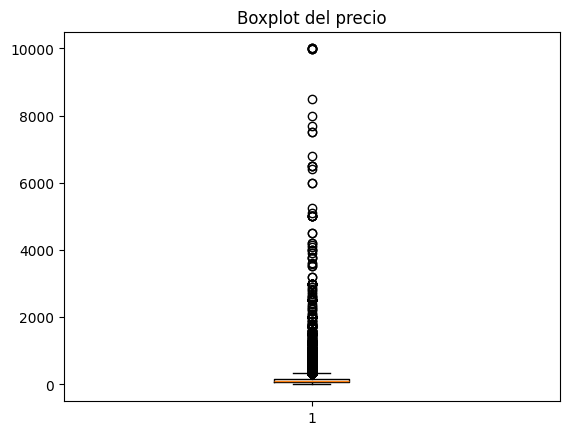

In [13]:
plt.boxplot(df['price'])
plt.title("Boxplot del precio")
plt.show()


Eliminamos valores atípicos basándonos en el rango intercuartílico.

In [14]:
### He analizado los outliers del precio usando el rango intercuartílico
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

df = df[(df['price'] >= lim_inf) & (df['price'] <= lim_sup)]


2.7 Creación de nuevas variables
2.7.1 Hosts profesionales

Los hosts con varias propiedades suelen tener un comportamiento distinto.
Creamos una columna que indique si un host administra tres o más propiedades.

In [15]:
pisos = df['host_id'].value_counts()
indicator1 = df['host_id'].map(pisos >= 3).astype(int)

posicion = df.columns.get_loc('host_id')
df.insert(posicion + 1, 'host_pro', indicator1)

### host_pro es una variable nueva que he creado para identificar si un anfitrión es profesional…”
# Vale 1 si tiene 3 o más propiedades, 0 si tiene menos.


3.....host_pro es una variable nueva que he creado.
Vale 1 si el anfitrión tiene 3 o más propiedades y 0 si tiene menos.
La idea es distinguir entre hosts profesionales, que gestionan varios pisos, y hosts particulares, que solo alquilan uno o dos. Esto puede influir en el precio, porque un host profesional suele tener más experiencia y una estrategia de precios más optimizada.”

2.8 Codificación de variables categóricas

Transformamos variables categóricas a formato numérico para que puedan ser utilizadas por algoritmos de machine learning.

Aplicamos One-Hot Encoding a las columnas relevantes.

In [16]:
df = pd.get_dummies(df, columns=['room_type'], drop_first=True)
df.head()
                                                                                    

,host_id,host_pro,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room
id,,,,,,,,,,,,,,,
2539,2787,1,Brooklyn,Kensington,40.64749,-73.97237,149,1,9,2018-10-19,0.21,6,365,True,False
2595,2845,0,Manhattan,Midtown,40.75362,-73.98377,225,1,45,2019-05-21,0.38,2,355,False,False
3647,4632,0,Manhattan,Harlem,40.80902,-73.94190,150,3,0,NaN,0.00,1,365,True,False
3831,4869,0,Brooklyn,Clinton Hill,40.68514,-73.95976,89,1,270,2019-07-05,4.64,1,194,False,False
5022,7192,0,Manhattan,East Harlem,40.79851,-73.94399,80,10,9,2018-11-19,0.10,1,0,False,False


He transformado variables categóricas a numéricas mediante One Hot Encoding para que el modelo pueda utilizarlas

2.9 Escalado de variables numéricas

El escalado es especialmente útil en modelos sensibles a la magnitud de las variables.
Aplicamos el escalado estándar a columnas numéricas seleccionadas.

El escalado permite que todas las variables tengan una magnitud similar, algo útil para modelos sensibles a la escala.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['price', 'minimum_nights', 'number_of_reviews']] = scaler.fit_transform(
    df[['price', 'minimum_nights', 'number_of_reviews']]
)


3. Análisis Exploratorio de Datos (EDA)

Realizamos visualizaciones para comprender distribuciones, patrones y relaciones entre variables.

### Analizamos la distribución del precio…
La matriz de correlación nos permite identificar relaciones entre variables…

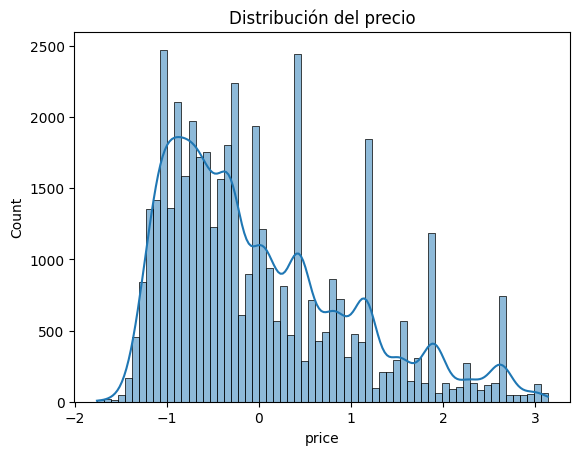

In [18]:
sns.histplot(df['price'], kde=True)
plt.title("Distribución del precio")
plt.show()


Matriz de correlación para detectar relaciones entre variables numéricas.

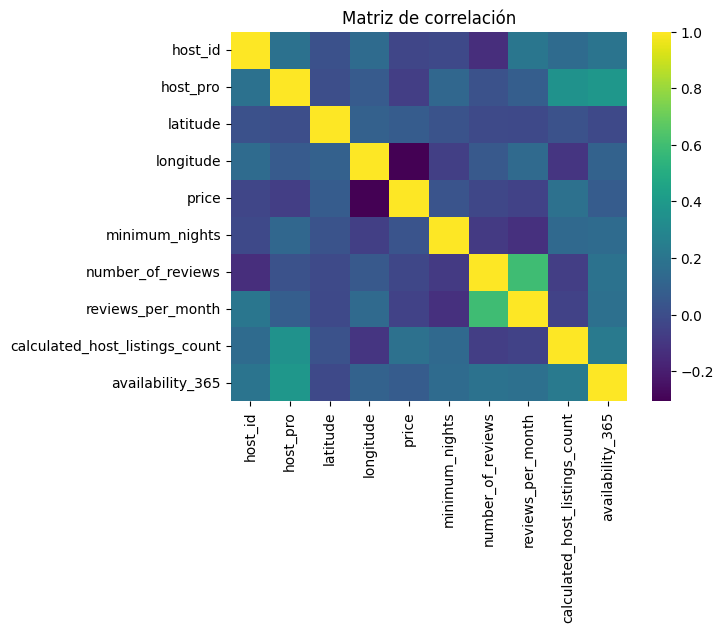

In [19]:
# Seleccionamos únicamente las columnas numéricas
df_num = df.select_dtypes(include=['int64', 'float64'])

# Matriz de correlación
sns.heatmap(df_num.corr(), cmap='viridis')
plt.title("Matriz de correlación")
plt.show()



Análisis del precio según tipo de habitación.

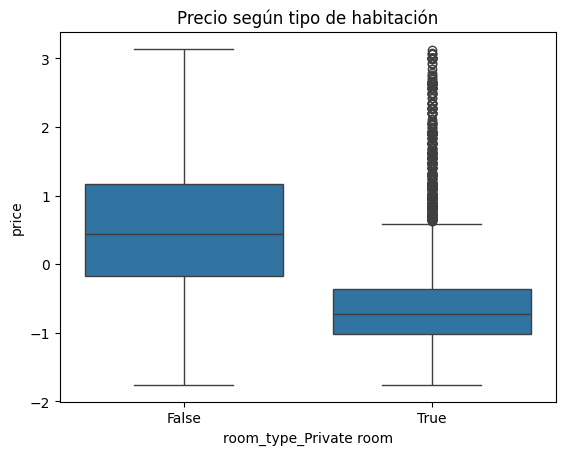

In [20]:
sns.boxplot(x='room_type_Private room', y='price', data=df)
plt.title("Precio según tipo de habitación")
plt.show()


4. Preparación final del dataset

Creamos la versión final del dataset limpia, preprocesada y lista para entrenar modelos de machine learning.

In [21]:
df_final = df.copy()
df_final.head()


,host_id,host_pro,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room
id,,,,,,,,,,,,,,,
2539,2787,1,Brooklyn,Kensington,40.64749,-73.97237,0.425971,-0.299033,-0.329753,2018-10-19,0.21,6,365,True,False
2595,2845,0,Manhattan,Midtown,40.75362,-73.98377,1.541168,-0.299033,0.464691,2019-05-21,0.38,2,355,False,False
3647,4632,0,Manhattan,Harlem,40.80902,-73.94190,0.440645,-0.198315,-0.528364,NaN,0.00,1,365,True,False
3831,4869,0,Brooklyn,Clinton Hill,40.68514,-73.95976,-0.454447,-0.299033,5.429964,2019-07-05,4.64,1,194,False,False
5022,7192,0,Manhattan,East Harlem,40.79851,-73.94399,-0.586510,0.154194,-0.329753,2018-11-19,0.10,1,0,False,False


He analizado los outliers del precio usando el rango intercuartílico.
Calculo Q1 y Q3, obtengo el IQR, y considero outliers los precios por debajo de Q1 - 1.5*IQR o por encima de Q3 + 1.5*IQR. He filtrado esos casos para evitar que valores extremos distorsionen la regresión.

Dataset final preparado correctamente para los modelos predictivos.

5. División del dataset en train y test

Antes de entrenar los modelos, dividimos los datos en conjunto de entrenamiento y de prueba.

In [22]:
from sklearn.model_selection import train_test_split

# Seleccionamos X e y
X = df_final.drop('price', axis=1)
y = df_final['price']

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


6. Regresión Lineal

Entrenamos un modelo de regresión lineal para predecir el precio de los alojamientos.

He usado un modelo de regresión lineal porque nuestro objetivo es predecir un valor numérico continuo, que es el precio. La regresión lineal intenta ajustar una combinación lineal de las variables explicativas para aproximar el precio.
Después evalúo el modelo con MAE, RMSE y R²:

MAE me dice el error medio en unidades de precio.

RMSE penaliza más los errores grandes.

R² me indica qué porcentaje de la variabilidad del precio está explicado por el modelo.

In [23]:
# Dejamos solo las columnas numéricas
df_final = df_final.select_dtypes(include=['int64', 'float64'])
df_final.head()


,host_id,host_pro,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,
2539,2787,1,40.64749,-73.97237,0.425971,-0.299033,-0.329753,0.21,6,365
2595,2845,0,40.75362,-73.98377,1.541168,-0.299033,0.464691,0.38,2,355
3647,4632,0,40.80902,-73.94190,0.440645,-0.198315,-0.528364,0.00,1,365
3831,4869,0,40.68514,-73.95976,-0.454447,-0.299033,5.429964,4.64,1,194
5022,7192,0,40.79851,-73.94399,-0.586510,0.154194,-0.329753,0.10,1,0


In [24]:
X = df_final.drop('price', axis=1)
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [25]:
from sklearn.linear_model import LinearRegression

modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

y_pred_lr = modelo_lr.predict(X_test)



7. Métricas del modelo de regresión lineal

Evaluamos el modelo mediante:

MAE (error absoluto medio)

RMSE (raíz del error cuadrático medio)

R² (porcentaje de variabilidad explicada)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("MAE  (Regresión lineal):", mae_lr)
print("RMSE (Regresión lineal):", rmse_lr)
print("R²   (Regresión lineal):", r2_lr)


MAE  (Regresión lineal): 0.7370253576853555
RMSE (Regresión lineal): 0.9303625062650409
R²   (Regresión lineal): 0.13701235399409029


8. Visualización: precio real vs precio predicho

Representamos el precio real frente al precio predicho por el modelo de regresión lineal.

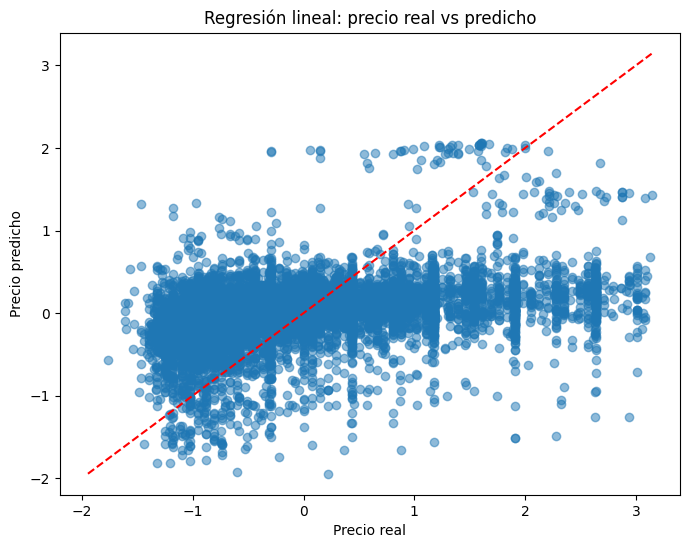

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Regresión lineal: precio real vs predicho")
# Línea ideal (y = x)
min_val = min(y_test.min(), y_pred_lr.min())
max_val = max(y_test.max(), y_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.show()
